<a href="https://colab.research.google.com/github/mawebi/charging-strategy/blob/main/ideal_charging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Source code definition
# Import required packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from math import floor, ceil
from scipy.optimize import curve_fit

# Extra time [min] used per charging stop (driving to the charger, plugin cable, ...)
extra_time_default = 8
# Start charging at percentage
start_at_percent_default = 10

# fitting functions
def quadratic(x, a, b, c):
  return a*x*x + b*x + c
def cubic(x, a, b, c): #d):
  return a*x*x*x + b*x*x + c*x #+ d
def poly(x, a, b, c, d, e):
  return a*(x**4) + b*(x**3) + c*x*x + d*x + e


class Car:
  def __init__(self, name, consumption_data, charging_data, capacity, start_at_percent=start_at_percent_default, extra_time=extra_time_default, speed_min=80, speed_max=200, distance_min=50, distance_max=300):
    self.name = name
    self.extra_time = extra_time
    self.capacity = capacity
    self.start_at_percent = start_at_percent
    self.consumption_x, self.consumption_y = zip(*consumption_data)
    self.charging_data = self._convertChargingCurve(charging_data, start_at_percent, capacity)    
    self.consumption_fitting_pars, _ = curve_fit(quadratic, self.consumption_x, self.consumption_y, bounds=(0,np.inf))
    x = np.array(self.charging_data)
    y = np.arange(start=1, stop=len(self.charging_data)+1, step=1)
    self.charging_fitting_pars, _ = curve_fit(cubic, x, y)  #bounds=([-np.inf,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,0]
    self.v = np.arange(start=speed_min, stop=speed_max, step=1)
    self.s = np.arange(start=distance_min, stop=distance_max, step=10)
  
  def _convertChargingCurve(self,charging_data, start_at, capacity, cut_slow_end=True):
    """Convert from percent array to kWh, truncate start"""
    # [...,87, 89, 89, 90] -> [...,87, 89] the curve ends when the percentage does not change in one minute
    if cut_slow_end:
      for idx, x in enumerate(charging_data):
        if idx > 0:
          if charging_data[idx-1] == charging_data[idx]:
            charging_data = charging_data[:idx]
            break
    
    for idx, x in enumerate(charging_data):
      if (start_at <= x):
        return [((c-charging_data[idx])*capacity/100.0) for c in charging_data[idx+1:]]

  def consumption(self, v):
    """Consumption [kWh] as function of speed [km/h]."""
    return quadratic(v, *self.consumption_fitting_pars)/1000.0

  def charging_time(self, energy_charged):
    """Charging time [min] as a function of charged energy [kWh]"""
    return cubic(energy_charged, *self.charging_fitting_pars)
  
  def effective_velocity(self, v, s):
    """"The effective speed including charging time and extra time per charging stop.
        The function depends on the driven speed v[km/h] and stage distance s [km]"""
    # time to drive distance s
    t1 = (s / v)
    # energy neccessary to drive distance s
    E = self.consumption(v) * s
    # time to charge E
    t2 = (self.charging_time(E)+ self.extra_time)/60.0
    return s/(t1+t2)

  def best_speed_with_fixed_distance(self, s):
    """Calculate the best driven speed [km/h] to get the best effective speed including charging times. The function depends on a fixed stage distance s [km]."""
    return self.v[np.argmax(self.effective_velocity(self.v, s))]

  @property
  def best_distance(self):
    """Calculates the distance with the highest effective speed."""
    best_overall_distance = self.s[np.argmax([self.effective_velocity(self.best_speed_with_fixed_distance(x),x) for x in self.s])]
    return best_overall_distance

  @property
  def best_velocity(self):
    """Calculates the best velocity based on the best distance"""
    best_overall_velocity = self.best_speed_with_fixed_distance(self.best_distance)
    return best_overall_velocity
  
  def __str__(self):
    return self.name

  def print_stats(self):
    b_s = self.best_distance
    b_v = self.best_velocity
    b_E = self.consumption(b_v) * b_s
    b_t = self.charging_time(b_E)
    b_p = ((b_E / self.capacity) * 100)+self.start_at_percent
    b_t_drive = (b_s / b_v) *60.0
    b_t_total = b_t+b_t_drive+self.extra_time
    b_veff = b_s/((b_t_total)/60.0)
    print("Stage parameter for car " + self.name)
    print("Best strategy is charging from %2d%% to %2d%%" % (self.start_at_percent, b_p))
    print("Effective velocity: %2.1f km/h" % b_veff)
    print("Best distance: %2d km" % b_s)
    print("Best velocity: %3d km/h" % b_v)
    print("Charging time: %2.1f min" % b_t)
    print("Driving time: %2.1f min" % b_t_drive)
    print("Extra time: %2.1f min" % self.extra_time)
    print("Total time: %2.1f min" % b_t_total)
    print("Charging energy: %3.2f kWh" % b_E)
  
  # plotting
  def plot_fixed_distance(self, s, fig=None):
    if fig == None:
      fig = plt.figure(figsize=(7, 5))
    plt.plot(self.v, self.effective_velocity(self.v, s), label=self.name + " s=%3dkm"%s)

  def plot_charging_curve(self, fig=None):
    x = np.array(self.charging_data)
    y = np.arange(start=1, stop=len(self.charging_data)+1, step=1)
    show = False
    if fig == None:
      fig = plt.figure(figsize=(7, 5))
      ax = fig.add_axes([0, 0, 1, 1])
      ax.set_xlabel('Energy to charge [kWh]', labelpad=10)
      ax.set_ylabel('Charging time [min]', labelpad=10)
      show = True

    plt.scatter(x, y, marker="+", color="red", label=self.name)
    plt.plot(x, cubic(x, *self.charging_fitting_pars),linestyle='--', linewidth=2, color='black', label='fit: %5.4f*x³ + %5.4fx² + %5.3fx' % tuple(self.charging_fitting_pars))
    if show:
      plt.legend()
      plt.show()

  def plot_consumption_curve(self, fig=None):
    if fig == None:
    # Create figure object and store it in a variable called 'fig'
      fig = plt.figure(figsize=(7, 5))
      # Add axes object to our figure that takes up entire figure
      ax = fig.add_axes([0, 0, 1, 1])
    # Plot the noisy exponential data
    plt.scatter(self.consumption_x, self.consumption_y, color='red', s=80, marker="o", label=self.name)
    x = np.arange(start=0, stop=200, step=2)
    plt.plot(x, quadratic(x, *self.consumption_fitting_pars), linestyle='--', linewidth=2, color='black', label='fit: %5.4f*x² + %5.3fx + %5.2f' % tuple(self.consumption_fitting_pars))
    # Add the x and y-axis labels
    ax.set_xlabel('Velocity [km/h]', labelpad=10)
    ax.set_ylabel('Consumption [Wh/km]', labelpad=10)
    plt.legend()
    plt.show()

In [ ]:
#@title Settings
#@markdown Define the extra time you need per charging stop (drive to charger, plugin, authenticate, ...)
extra_time_per_stop = 8 #@param {type:"slider", min:0, max:20, step:1}
#@markdown Start charging at percentage (SoC) in %:
start_charging_at = 10 #@param {type:"slider", min:10, max:40, step:5}

In [ ]:
cars = []
#@title # Car definitions
#@markdown Instruction: Consumption as function of speed is an array in (km/h,Wh); battery capacity in kWh and charging curve is SoC recorded accurate every minute.
#@markdown ## Car 1
name = 'ID.4 RWD 77kWh Software 2.4' #@param {type:"string"}
capacity = 77.0 #@param {type:"number"}
consumption = [( 86.7, 137),(107.2, 170),(116.9, 205), (150, 300)] #@param {type:"raw"}
charging_curve = [3,5,8,10,12,15,17,19,24,27,31,34,35,38,40,42,45,47,49,51,53,55,57,59,61,62,64,65,67,68,70,71,73,74,75,77,78,79,81,82,83,84,85,86,87,88,89,90,91,91,92,93,93,94,95,95,96,97,97] #@param {type:"raw"}
cars.append(Car(name, consumption, charging_curve, capacity, start_at_percent=start_charging_at, extra_time=extra_time_per_stop))
#@markdown Data sources: Youtube Channel Battery Life
#@markdown - <sub><sup>https://docs.google.com/spreadsheets/d/1cDlLxhUQsuCXLG0h_SnDPX8BIy0VpI32jDNrInWsMrA
#@markdown - <sub><sup>https://www.youtube.com/watch?v=Y4ZzUNs3mCg&list=PLwCzgH6q6jksw-5kii9PBDvB1Lqqw7IS6&index=25
#@markdown ---
#@markdown ## Car 2
name = 'ID.4 RWD 77kWh Software 3.0' #@param {type:"string"}
capacity = 77.0 #@param {type:"number"}
consumption = [( 86.7, 137),(107.2, 170),(116.9, 205), (150, 300)] #@param {type:"raw"}
charging_curve =  [4,6,10,13,16,19,22,25,28,31,34,37,40,43,45,48,51,53,56,59,61,64,66,68,71,73,75,77,79,80,82,83,84,85,86,87,87,88,88,89,90,90] #@param {type:"raw"}
cars.append(Car(name, consumption, charging_curve, capacity, start_at_percent=start_charging_at, extra_time=extra_time_per_stop))
#@markdown Data sources: Youtube Channel Battery Life
#@markdown Charging curve from ID.3 77 kWh Software 3.0, consumption ID.4
#@markdown - <sub><sup>https://docs.google.com/spreadsheets/d/1cDlLxhUQsuCXLG0h_SnDPX8BIy0VpI32jDNrInWsMrA
#@markdown - <sub><sup>https://www.youtube.com/watch?v=Y4ZzUNs3mCg&list=PLwCzgH6q6jksw-5kii9PBDvB1Lqqw7IS6&index=25
#@markdown ---
#@markdown ## Car 3
name = 'Enyaq RS 77kWh Software 3.0' #@param {type:"string"}
capacity = 77.0 #@param {type:"number"}
consumption = [( 86.7, 137),(107.2, 170),(116.9, 205), (150, 300)] #@param {type:"raw"}
charging_curve = [7,11,15,19,23,26,29,32,35,38,40,42,44,46,48,50,52,54,56,57,59,61,62,64,65,66,68,69,71,72,73,75,76,77,79,80,81,83,84,85,86,87,88,89,89] #@param {type:"raw"}
cars.append(Car(name, consumption, charging_curve, capacity, start_at_percent=start_charging_at, extra_time=extra_time_per_stop))
#@markdown Data sources: Youtube Channel Battery Life
#@markdown Charging curve from Enyaq Coupe RS 77 kWh Software 3.0, consumption ID.4
#@markdown - <sub><sup>https://docs.google.com/spreadsheets/d/1cDlLxhUQsuCXLG0h_SnDPX8BIy0VpI32jDNrInWsMrA
#@markdown - <sub><sup>https://www.youtube.com/watch?v=Y4ZzUNs3mCg&list=PLwCzgH6q6jksw-5kii9PBDvB1Lqqw7IS6&index=25
#@markdown ---

In [ ]:
#@title Plot data fitting curves as check
#@markdown Show/Plot the fitting curves of the input data to check if the fit is reasonable.
import ipywidgets as widgets
from IPython.display import display
button1 = widgets.Button(description="Show consumption")
output1 = widgets.Output()

button2 = widgets.Button(description="Show charging")
output2 = widgets.Output()

def on_button1_clicked(b):
  with output1:
    for c in cars:
      c.plot_consumption_curve()

def on_button2_clicked(b):
  with output2:
    for c in cars:
      c.plot_charging_curve()

button1.on_click(on_button1_clicked)
button2.on_click(on_button2_clicked)
display(button1, output1)
display(button2, output2)

Button(description='Show consumption', style=ButtonStyle())

Output()

Button(description='Show charging', style=ButtonStyle())

Output()

In [ ]:
#@title Best stage parameters for fastest travel { run: "auto" }
car_number = "All" #@param ["Car 1", "Car 2", "Car 3", "All"]

if car_number == "All":
  for c in cars:
    c.print_stats()
    print("-"*60)
else:
  for idx, s in enumerate(["Car 1", "Car 2", "Car 3"]):
    if car_number == s:
      cars[idx].print_stats()


Stage parameter for car ID.4 RWD 77kWh Software 2.4
Best strategy is charging from 10% to 59%
Effective velocity: 96.3 km/h
Best distance: 120 km
Best velocity: 155 km/h
Charging time: 20.3 min
Driving time: 46.5 min
Extra time: 8.0 min
Total time: 74.7 min
Charging energy: 37.96 kWh
------------------------------------------------------------
Stage parameter for car ID.4 RWD 77kWh Software 3.0
Best strategy is charging from 10% to 70%
Effective velocity: 101.7 km/h
Best distance: 140 km
Best velocity: 160 km/h
Charging time: 22.1 min
Driving time: 52.5 min
Extra time: 8.0 min
Total time: 82.6 min
Charging energy: 46.72 kWh
------------------------------------------------------------
Stage parameter for car Enyaq RS 77kWh Software 3.0
Best strategy is charging from 10% to 51%
Effective velocity: 97.1 km/h
Best distance: 100 km
Best velocity: 156 km/h
Charging time: 15.3 min
Driving time: 38.5 min
Extra time: 8.0 min
Total time: 61.8 min
Charging energy: 31.97 kWh
----------------------

# Effective speed with fixed distance

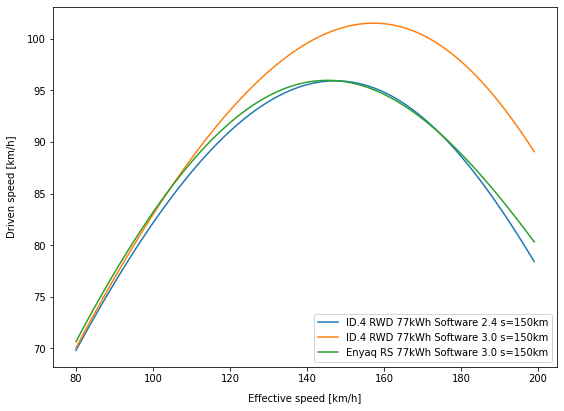

In [ ]:
#@title Comparison cars { run: "auto" }
#@markdown The effective speed (including charging stops) as a function of the driven speed.
#@markdown Here the cars are compared with the same fixed stage distance s in [km].
fixed_distance = 150 #@param {type:"slider", min:80, max:300, step:10}

fig = plt.figure(figsize=(7, 5))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])

for c in cars:
  c.plot_fixed_distance(fixed_distance, fig)
# Add the x and y-axis labels
ax.set_xlabel('Effective speed [km/h]', labelpad=10)
ax.set_ylabel('Driven speed [km/h]', labelpad=10)
plt.legend()
plt.show()


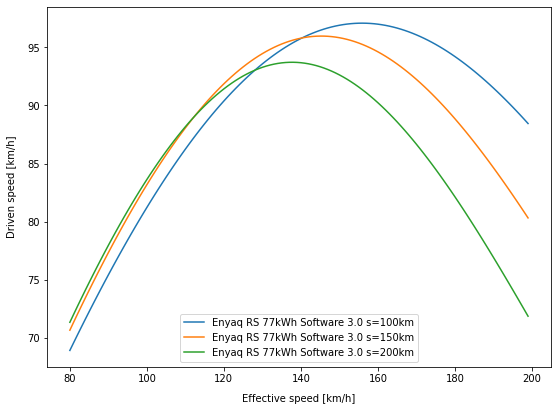

In [ ]:
#@title Different stage distance { run: "auto" }
#@markdown The effective speed (including charging stops) as a function of the driven speed.
#@markdown Here the cars are compared with the same fixed stage distance s in [km].
fixed_distance1 = 100 #@param {type:"slider", min:80, max:300, step:10}
fixed_distance2 = 150 #@param {type:"slider", min:80, max:300, step:10}
fixed_distance3 = 200 #@param {type:"slider", min:80, max:300, step:10}
car_number = "Car 3" #@param ["Car 1", "Car 2", "Car 3"]

fig = plt.figure(figsize=(7, 5))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])
for idx, s in enumerate(["Car 1", "Car 2", "Car 3"]):
  if car_number == s:
    cars[idx].plot_fixed_distance(fixed_distance1, fig)
    cars[idx].plot_fixed_distance(fixed_distance2, fig)
    cars[idx].plot_fixed_distance(fixed_distance3, fig)

# Add the x and y-axis labels
ax.set_xlabel('Effective speed [km/h]', labelpad=10)
ax.set_ylabel('Driven speed [km/h]', labelpad=10)
plt.legend()
plt.show()


# old code

In [ ]:
# New Code Inputs

# ID3 77 / ID4 Pro 77 / Enyaq 80 with software 2.x
meb_77kw_software2 = [3,5,8,10,12,15,17,19,24,27,31,34,35,38,40,42,45,47,49,51,53,55,57,59,61,62,64,65,67,68,70,71,73,74,75,77,78,79,81,82,83,84,85,86,87,88,89,90,91,91,92,93,93,94,95,95,96,97,97]
# ID4 Pro / Enyaq 80 with software 3.0                    
meb_77kw_software3 = [4,6,10,13,16,19,22,25,28,31,34,37,40,43,45,48,51,53,56,59,61,64,66,68,71,73,75,77,79,80,82,83,84,85,86,87,87,88,88,89,90,90]
# ID4/5 GTX / Enyaq RS/80x
mebX_77kw_software3 = [7,11,15,19,23,26,29,32,35,38,40,42,44,46,48,50,52,54,56,57,59,61,62,64,65,66,68,69,71,72,73,75,76,77,79,80,81,83,84,85,86,87,88,89,89]
# Ioniq 5
ioniq_5 = [7,9,12,16,20,24,29,34,38,43,48,51,54,57,61,64,68,71,74,77,79,82,84,86,87,88,90,91,91,92,93,94,94,95,95]
# source
# https://docs.google.com/spreadsheets/d/1cDlLxhUQsuCXLG0h_SnDPX8BIy0VpI32jDNrInWsMrA
# source https://www.youtube.com/watch?v=Y4ZzUNs3mCg&list=PLwCzgH6q6jksw-5kii9PBDvB1Lqqw7IS6&index=25

# Energy consumption depending on driven speed in (km/h, Wh/km)
consumption_ID4_77kWh = [ ( 86.7, 137),
                          (107.2, 170),
                          (116.9, 205), (150, 300) ]
# charged kWh starting from 10% in minutes steps
# ID3 77 / ID4 Pro 77 / Enyaq 80 with software 2.x
meb_77kw_software2 = [1.54,3.85,5.39,6.93,10.78,13.09,16.17,18.48,19.25,21.56,23.1,24.64,26.95,28.49,30.03,31.57,33.11,34.65,36.19,37.73,39.27,40.04,41.58,42.35,43.89,44.66,46.2,46.97,48.51,49.28,50.05,51.59,52.36,53.13,54.67,55.44,56.21,56.98,57.75,58.52,59.29]
# ID4 Pro / Enyaq 80 with software 3.0                    
meb_77kw_software3 = [2.31,4.62,6.93,9.24,11.55,13.86,16.17,18.48,20.79,23.1,25.41,26.95,29.26,31.57,33.11,35.42,37.73,39.27,41.58,43.12,44.66,46.97,48.51,50.05,51.59,53.13,53.9,55.44,56.21,56.98,57.75,58.52,59.29]
# ID4/5 GTX / Enyaq RS/80x
mebX_77kw_software3 = [3.08,6.16,9.24,11.55,13.86,16.17,18.48,20.79,22.33,23.87,25.41,26.95,28.49,30.03,31.57,33.11,34.65,35.42,36.96,38.5,39.27,40.81,41.58,42.35,43.89,44.66,46.2,46.97,47.74,49.28,50.05,50.82,52.36,53.13,53.9,55.44,56.21,56.98,57.75,58.52,59.29]
# Ioniq 5
ioniq_5 = [2.904,5.808,8.712,12.342,15.972,18.876,22.506,26.136,28.314,30.492,32.67,35.574,37.752,40.656,42.834,45.012,47.19,48.642,50.82,52.272,53.724,54.45,55.176,56.628]
# source
# https://docs.google.com/spreadsheets/d/1cDlLxhUQsuCXLG0h_SnDPX8BIy0VpI32jDNrInWsMrA
# source https://www.youtube.com/watch?v=Y4ZzUNs3mCg&list=PLwCzgH6q6jksw-5kii9PBDvB1Lqqw7IS6&index=25


testprozent = [4,8,12,15,19,23,26,29,32,35,38,40,42,44,46,48,50,52,54,56,58,60,62,63,65,66,68,69,70,72,73,74,76,77,78,80,81,82,84,85,86,87,88,88]
 
c = Car("MEB_77kWh_175kW", consumption_ID4_77kWh, testprozent, 77.0)
c.plot_consumption_curve()
c.print_stats()


## Fitting data

In [ ]:
energy_consumption_x, energy_consumption_y  = zip(*consumption_ID4_77kWh)

# Energy consumption function
def quadratic(x, a, b, c):
  return a*x*x + b*x + c

consumption_fitting_pars, cov = curve_fit(quadratic, energy_consumption_x, energy_consumption_y, bounds=(0,np.inf))

# Energy consumption function [kWh/km]
def consumption(v):
  return quadratic(v, *consumption_fitting_pars)/1000.0

## Plotting curve

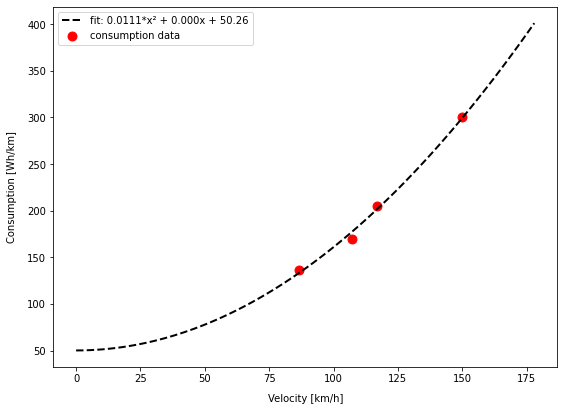

In [ ]:
# plot
# Create figure object and store it in a variable called 'fig'
fig = plt.figure(figsize=(7, 5))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])

# Plot the noisy exponential data
ax.scatter(energy_consumption_x, energy_consumption_y, color='red', s=80, marker="o", label='consumption data')
x = np.arange(start=0, stop=180, step=2)
ax.plot(x, quadratic(x, *consumption_fitting_pars), linestyle='--', linewidth=2, color='black', label='fit: %5.4f*x² + %5.3fx + %5.2f' % tuple(consumption_fitting_pars))
# Add the x and y-axis labels
ax.set_xlabel('Velocity [km/h]', labelpad=10)
ax.set_ylabel('Consumption [Wh/km]', labelpad=10)
plt.legend()
plt.show()

# Input charging data

In [ ]:
# charged kWh starting from 10% in minutes steps
# ID3 77 / ID4 Pro 77 / Enyaq 80 with software 2.x
meb_77kw_software2 = [1.54,3.85,5.39,6.93,10.78,13.09,16.17,18.48,19.25,21.56,23.1,24.64,26.95,28.49,30.03,31.57,33.11,34.65,36.19,37.73,39.27,40.04,41.58,42.35,43.89,44.66,46.2,46.97,48.51,49.28,50.05,51.59,52.36,53.13,54.67,55.44,56.21,56.98,57.75,58.52,59.29]
# ID4 Pro / Enyaq 80 with software 3.0
meb_77kw_software3 = [2.31,4.62,6.93,9.24,11.55,13.86,16.17,18.48,20.79,23.1,25.41,26.95,29.26,31.57,33.11,35.42,37.73,39.27,41.58,43.12,44.66,46.97,48.51,50.05,51.59,53.13,53.9,55.44,56.21,56.98,57.75,58.52,59.29]
# ID4/5 GTX / Enyaq RS/80x
mebX_77kw_software3 = [3.08,6.16,9.24,11.55,13.86,16.17,18.48,20.79,22.33,23.87,25.41,26.95,28.49,30.03,31.57,33.11,34.65,35.42,36.96,38.5,39.27,40.81,41.58,42.35,43.89,44.66,46.2,46.97,47.74,49.28,50.05,50.82,52.36,53.13,53.9,55.44,56.21,56.98,57.75,58.52,59.29]
# Ioniq 5
ioniq_5 = [2.904,5.808,8.712,12.342,15.972,18.876,22.506,26.136,28.314,30.492,32.67,35.574,37.752,40.656,42.834,45.012,47.19,48.642,50.82,52.272,53.724,54.45,55.176,56.628]
# source
# https://docs.google.com/spreadsheets/d/1cDlLxhUQsuCXLG0h_SnDPX8BIy0VpI32jDNrInWsMrA

[6.55193198e-05 1.03250539e-03 3.84319222e-01 6.57698303e-01]
[ 1.00976992e-04 -5.40429191e-03  5.05744766e-01  4.24885292e-18]
[-5.08013301e-06  8.29673655e-03  2.06276038e-01  4.03389529e-01]
[ 9.34360401e-05 -4.52720877e-03  3.72110829e-01  1.22241785e-22]


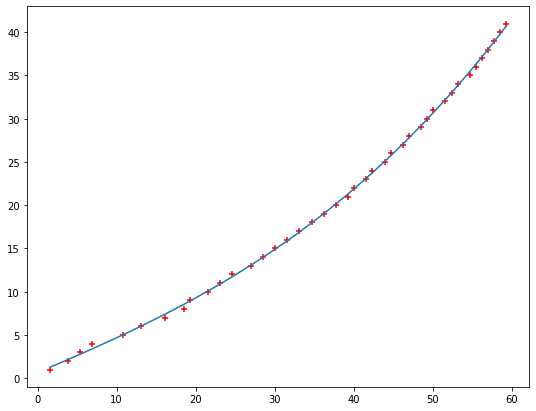

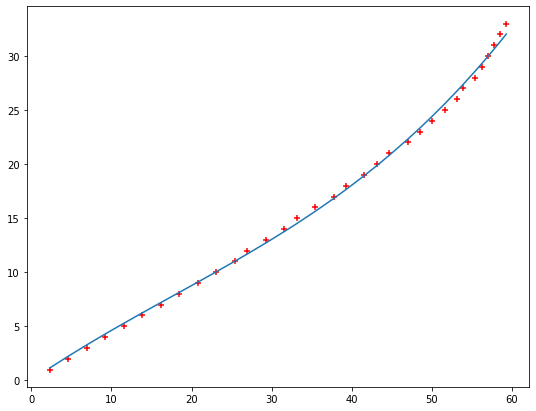

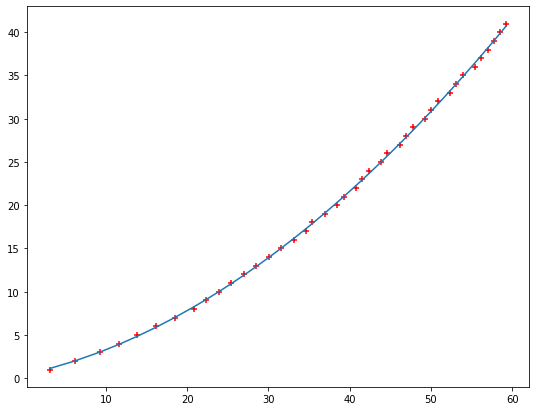

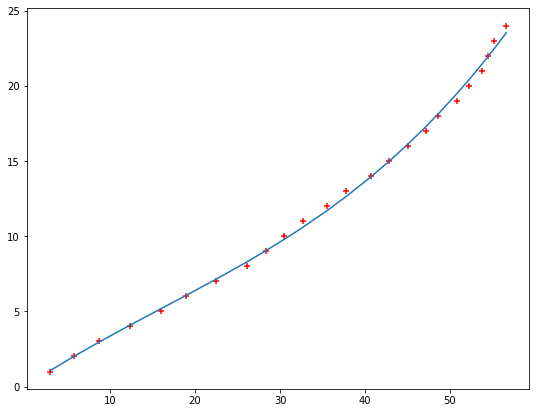

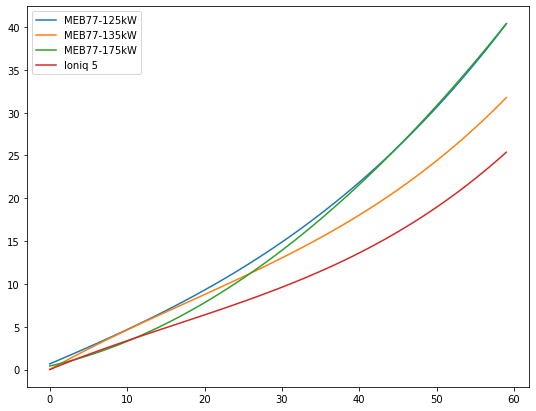

Charging from 10% - 80% (125kW): 34.7 min
Charging from 10% - 80% (135kW): 27.5 min
Charging from 10% - 80% (175kW): 34.9 min


In [ ]:
def cubic(x, a, b, c, d):
  return a*x*x*x + b*x*x + c*x + d

#avg_power_pars, cov = curve_fit(cubic, xdata=x_time, ydata=[total_energy(round(x)) for x in x_time])
#plt.plot(x_time, cubic(x_time, *avg_power_pars))
x = np.arange(start=0, stop=60, step=1)

#fitting
x1 = np.array(meb_77kw_software2)
y1 = np.arange(start=1, stop=len(meb_77kw_software2)+1, step=1)
charging_time_from_energy_charged_para1, cov = curve_fit(cubic, x1, y1, bounds=([-np.inf,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf]))
print(charging_time_from_energy_charged_para1)

x2 = np.array(meb_77kw_software3)
y2 = np.arange(start=1, stop=len(meb_77kw_software3)+1, step=1)
charging_time_from_energy_charged_para2, cov = curve_fit(cubic, x2, y2, bounds=([-np.inf,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf]))
print(charging_time_from_energy_charged_para2)

x3 = np.array(mebX_77kw_software3)
y3 = np.arange(start=1, stop=len(mebX_77kw_software3)+1, step=1)
charging_time_from_energy_charged_para3, cov = curve_fit(cubic, x3, y3, bounds=([-np.inf,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf]))
print(charging_time_from_energy_charged_para3)

x4 = np.array(ioniq_5)
y4 = np.arange(start=1, stop=len(ioniq_5)+1, step=1)
charging_time_from_energy_charged_para4, cov = curve_fit(cubic, x4, y4, bounds=([-np.inf,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf]))
print(charging_time_from_energy_charged_para4)

plt.figure(figsize=(9, 7))
plt.scatter(x1, y1, marker="+", color="red", label="MEB77-125kW")
plt.plot(x1, cubic(x1, *charging_time_from_energy_charged_para1))

plt.figure(figsize=(9, 7))
plt.scatter(x2, y2, marker="+", color="red", label="MEB77-135kW")
plt.plot(x2, cubic(x2, *charging_time_from_energy_charged_para2))

plt.figure(figsize=(9, 7))
plt.scatter(x3, y3, marker="+", color="red", label="MEB77-175kW")
plt.plot(x3, cubic(x3, *charging_time_from_energy_charged_para3))

plt.figure(figsize=(9, 7))
plt.scatter(x4, y4, marker="+", color="red", label="Ioniq 5")
plt.plot(x4, cubic(x4, *charging_time_from_energy_charged_para4))

plt.figure(figsize=(9, 7))
plt.plot(x, cubic(x, *charging_time_from_energy_charged_para1), label="MEB77-125kW")
plt.plot(x, cubic(x, *charging_time_from_energy_charged_para2), label="MEB77-135kW")
plt.plot(x, cubic(x, *charging_time_from_energy_charged_para3), label="MEB77-175kW")
plt.plot(x, cubic(x, *charging_time_from_energy_charged_para4), label="Ioniq 5")
plt.legend()
plt.show()
def charging_time_from_energy_charged_meb_77kw_software2(energy_charged, extra=5):
  return cubic(energy_charged, *charging_time_from_energy_charged_para1)+extra
def charging_time_from_energy_charged_meb_77kw_software3(energy_charged, extra=5):
  return cubic(energy_charged, *charging_time_from_energy_charged_para2)+extra
def charging_time_from_energy_charged_mebX_77kw_software3(energy_charged, extra=5):
  return cubic(energy_charged, *charging_time_from_energy_charged_para3)+extra
def charging_time_from_energy_charged_ioniq_5(energy_charged, extra=5):
  return cubic(energy_charged, *charging_time_from_energy_charged_para4)+extra


print("Charging from 10%% - 80%% (125kW): %2.1f min" % charging_time_from_energy_charged_meb_77kw_software2(54,0))
print("Charging from 10%% - 80%% (135kW): %2.1f min" % charging_time_from_energy_charged_meb_77kw_software3(54,0))
print("Charging from 10%% - 80%% (175kW): %2.1f min" % charging_time_from_energy_charged_mebX_77kw_software3(54,0))

# Effective Velocity

Best strategy is charging from 10% to 65%
Effective velocity: 97.1 km/h
Best distance: 100 km
Best velocity: 156 km/h
Charging time: 15.3 min
Driving time: 38.5 min
Extra time: 8.0 min
Total time: 61.8 min
Charging energy: 31.97 kWh


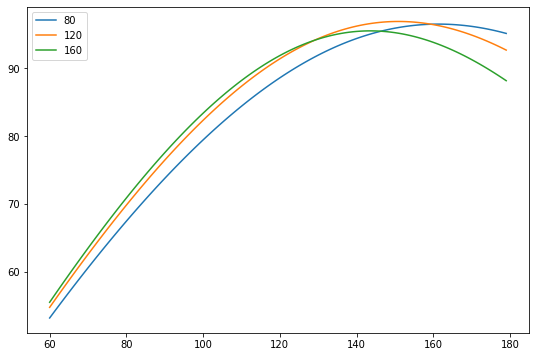

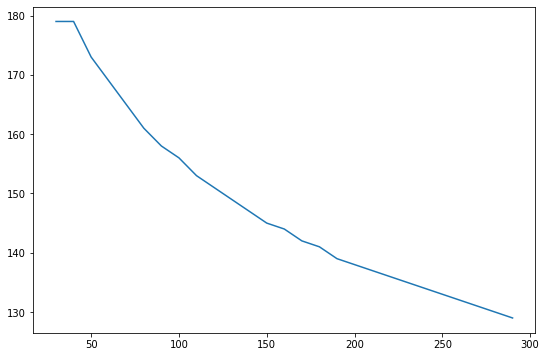

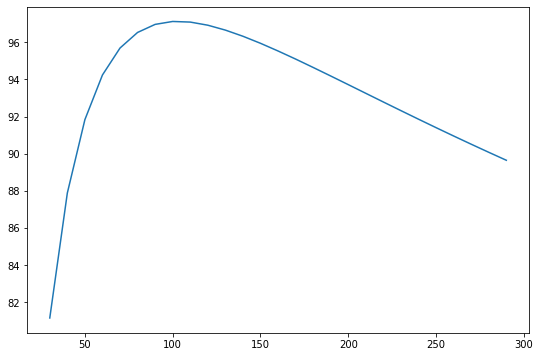

In [ ]:
#Calculate effective velocity

extra_time = 8 # extra time

velocity_display_from = 60
velocity_display_to = 180
v = np.arange(start=velocity_display_from, stop=velocity_display_to, step=1)

#charging_time_from_energy_charged_meb_77kw_software2
#charging_time_from_energy_charged_meb_77kw_software3
#charging_time_from_energy_charged_mebX_77kw_software3
#charging_time_from_energy_charged_ioniq_5

def charging_time(e, extra=extra_time):
  return charging_time_from_energy_charged_mebX_77kw_software3(e, extra)

def effective_velocity(v, s, extra=extra_time):
  # time to drive distance s
  t1 = (s / v)
  #print(t1)
  # energy neccessary to drive distance s
  E = consumption(v) * s
  #print(E)
  # time to charge E
  t2 = charging_time(E, extra)/60.0
  #print(t2)
  return s/(t1+t2)

def best_velocity_fixed_distance(s, extra=extra_time):
  return v[np.argmax(effective_velocity(v, s, extra))]

#print(effective_velocity(100, 100))
plt.figure(figsize=(9,6))
plt.plot(v, effective_velocity(v, 80), label="80")
plt.plot(v, effective_velocity(v, 120), label="120")
plt.plot(v, effective_velocity(v, 160), label="160")
#plt.plot(v, effective_velocity(v, 200), label="200")
plt.legend()

# best distance
s = np.arange(start=30, stop=300, step=10)
plt.figure(figsize=(9,6))
plt.plot(s, [best_velocity_fixed_distance(x) for x in s])
plt.figure(figsize=(9,6))
plt.plot(s, [effective_velocity(best_velocity_fixed_distance(x),x) for x in s])

best_overall_distance = s[np.argmax([effective_velocity(best_velocity_fixed_distance(x),x) for x in s])]
best_overall_velocity = best_velocity_fixed_distance(best_overall_distance)

b_s = best_overall_distance
#b_s = 150
b_v = best_velocity_fixed_distance(b_s)
b_E = consumption(b_v) * b_s
b_t = charging_time(b_E, extra=0)
b_p = ((b_E / 58.0) * 100)+10
b_t_drive = (b_s / b_v) *60.0
b_t_total = b_t+b_t_drive+extra_time
b_veff = b_s/((b_t_total)/60.0)
print("Best strategy is charging from 10%% to %2d%%" % b_p)
print("Effective velocity: %2.1f km/h" % b_veff)
print("Best distance: %2d km" % b_s)
print("Best velocity: %3d km/h" % b_v)
print("Charging time: %2.1f min" % b_t)
print("Driving time: %2.1f min" % b_t_drive)
print("Extra time: %2.1f min" % extra_time)
print("Total time: %2.1f min" % b_t_total)
print("Charging energy: %3.2f kWh" % b_E)
